# Experimenting with naive Bayes classifiers and linear support vector machine classifiers
Reference: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#extracting-features-from-text-files

In [2]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

sns.set(rc={'axes.facecolor':'white'})


In [3]:
# import dataset
train_path = "../data/train.csv"

train_data = pd.read_csv(train_path)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144293 entries, 0 to 144292
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  144293 non-null  object 
 1   discourse_id        144293 non-null  float64
 2   discourse_start     144293 non-null  float64
 3   discourse_end       144293 non-null  float64
 4   discourse_text      144293 non-null  object 
 5   discourse_type      144293 non-null  object 
 6   discourse_type_num  144293 non-null  object 
 7   predictionstring    144293 non-null  object 
dtypes: float64(3), object(5)
memory usage: 8.8+ MB


## Pre-processing

In order to verify the accuracy of the model prediction, it is customary in machine learning to split the dataset into a training set and a test set. The model is trained on the training set only, and then tested on the remaining data. The accuracy is compute by comparing the predicted values for the test set against the known values.

Accuracy over the training set can be similarly measured. Hoverer a very high accuracy over the training set can be a result of overtraining and therefore be a poor predictor of how the model is going to perform on new data.

We denote X the features (in this case, the text segments) and y the target variable (in this case, the discourse type).

In [4]:
X = train_data['discourse_text']
y = train_data['discourse_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=29)

Use CountVectorizer to automatically builds a dictionary of features. 
Reference: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

By default words are case insensitive. This feature can be manually switched off.

The optional parameter stop_words can be passed to provide a list of words to ignore during the classification. There is default list for the English language, but it likely contains the very prepositions and conjunctions which are useful for this project.

CountVectorizer also supports N-grams of words or consecutive characters, by passing in an optional parameter.

In [5]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(101005, 41751)

Once fitted, the vectorizer has built a dictionary of feature indices. 

The index value of a word in the vocabulary is linked to its frequency in the whole training corpus.

In [6]:
# sample usage
print(count_vect.vocabulary_.get(u'and'))
print(count_vect.vocabulary_.get(u'but'))

2295
5610


Machine learning models tend to perform better on normalized data. For this reason, we use tf-idf (term frequency–inverse document frequency).  
Reference: https://en.wikipedia.org/wiki/Tf%E2%80%93idf

In simple terms, we consider frequencies instead of occurrences, and we also reduce the impact of words which are common in most of the text samples (e.g. 'the').

In [7]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape


(101005, 41751)

## Multinomial classifier (naive Bayes)

A multinomial classifier is a type of naive Bayesian classifier. It is naive in the sense that it computes the probability of each word appearing in any discourse type and uses the inferred probability distribution to make predictions on new data.

In [8]:
# create and train multinomial classifier
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [9]:
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

predicted = clf.predict(X_test_tfidf)

for i in range(10):
  print('text: ', X_test.iloc[i])
  print('predicted category: ', predicted[i])
  print('real category: ', y_test.iloc[i])  

text:   Students should not be allowed to design their summer projects 
predicted category:  Claim
real category:  Position
text:  Finally, The FACS could help find if students are depressed or having problems at home.
predicted category:  Claim
real category:  Claim
text:  You might say that not all sports are right after school, and I'd say that is correct,
predicted category:  Evidence
real category:  Counterclaim
text:  Every student should do at least 2 community services. Maybe one at home and one at school
predicted category:  Claim
real category:  Evidence
text:  Social Skills are a key component of learning through any type of school. The interaction between other students is extremely valuable because it builds relationships and confidence. 
predicted category:  Claim
real category:  Claim
text:  Where as if I'm at home I can be free complete things on my time, I can take time on my assignments, I don't have to compare myself to others, and I can be me. At home there is no on

In [10]:
# same thing with pipeline

# text_clf = Pipeline([
#   ('vect', CountVectorizer()),
#   ('tfidf', TfidfTransformer()),
#   ('clf', MultinomialNB()),
# ])
# text_clf.fit(X_train, y_train)


## Performance - Multinomial Classifier

In [11]:
accuracy = np.mean(predicted == y_test)
print('accuracy: ', accuracy )

accuracy:  0.4969275549805951


...meh.


Still, it is better than random!  
With 7 categories, there is approximately a 14.2% chance to randomly get it right. 

It is a start.  
Let us try to to understand what happened and where the model made most mistakes.

In [12]:
discourse_types = list(set(train_data["discourse_type"]))
all_value_counts = train_data["discourse_type"].value_counts()
train_value_counts = y_train.value_counts()
test_value_counts = y_test.value_counts()

def percent(array):
  # array must constain at least a non-zero entry
  tot = sum(array)
  return [round((el / tot) * 100, 2) for el in array]

value_counts = pd.DataFrame({
    'all': all_value_counts.array, 
    'train': train_value_counts.array, 
    'test': test_value_counts.array,
    'all %': percent(all_value_counts.array), 
    'train %': percent(train_value_counts.array), 
    'test %': percent(test_value_counts.array)
  }, index=all_value_counts.index)
print(value_counts)

                        all  train   test  all %  train %  test %
Claim                 50208  35266  14942  34.80    34.92   34.52
Evidence              45702  32073  13629  31.67    31.75   31.48
Position              15419  10792   4627  10.69    10.68   10.69
Concluding Statement  13505   9352   4153   9.36     9.26    9.59
Lead                   9305   6513   2792   6.45     6.45    6.45
Counterclaim           5817   4060   1757   4.03     4.02    4.06
Rebuttal               4337   2949   1388   3.01     2.92    3.21


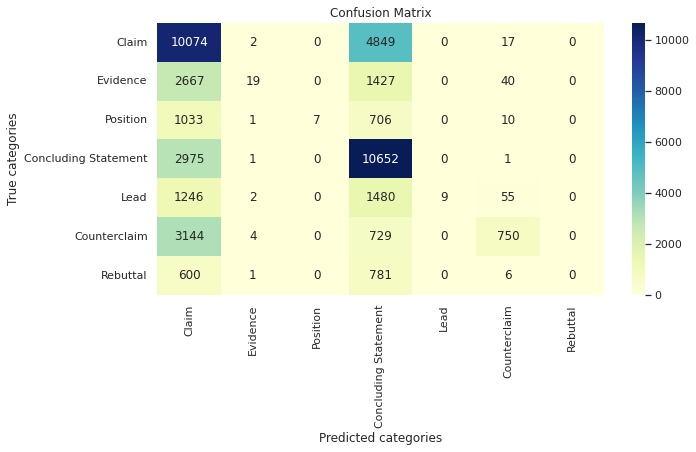

In [13]:

confusion_matrix = metrics.confusion_matrix(
  y_test, predicted, labels=clf.classes_)
# print(confusion_matrix)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax, cmap="YlGnBu")
# annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted categories')
ax.set_ylabel('True categories'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels(all_value_counts.index, rotation=90)
ax.set_yticklabels(all_value_counts.index, rotation=0)
plt.show()

- The model never predicted 'Rebuttal' as a category. This category has the lowest number of samples in the dataset and it seems like it also has the least characteristic vocabulary. This may be the hardest category to correctly label even with more sophisticated algorithms.

- Whenever the model predicted 'Position' or 'Lead', it got it right.However, many 'Position' and 'Lead' texts were mislabeled as other categories.

- The most frequent mistake was the prediction of 'Concluding statement' where 'Claim' was the actual category.

## Linear Support Vector Machine Classifier  
Reference: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

In [14]:
clf2 = Pipeline([
  ('vect', CountVectorizer()),
  ('tfidf', TfidfTransformer()),
  ('clf', SGDClassifier(loss='hinge', penalty='l2',
                        alpha=1e-3, random_state=29,
                        max_iter=5, tol=None)),
])
clf2.fit(X_train, y_train)
predicted2 = clf2.predict(X_test)

## Performance - Linear Support Vector Machine

In [15]:
accuracy2 = np.mean(predicted2 == y_test)
print('accuracy: ', accuracy2 )

accuracy:  0.5893781186472001


Linear support vector machine improves!

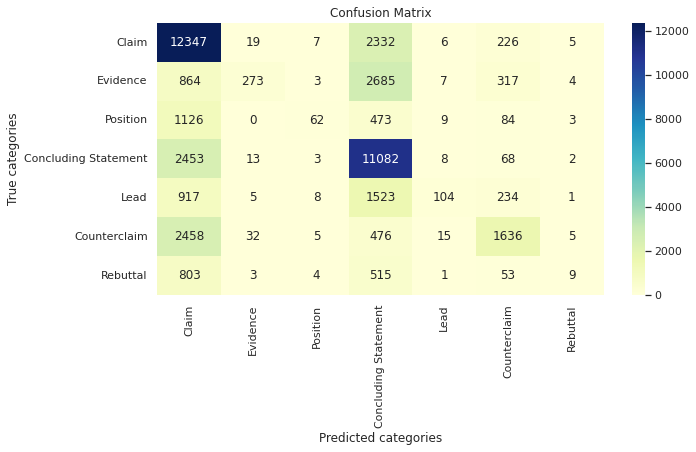

In [16]:
confusion_matrix2 = metrics.confusion_matrix(
  y_test, predicted2, labels=clf2.classes_)
# print(confusion_matrix)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.heatmap(confusion_matrix2, annot=True, fmt='g', ax=ax, cmap="YlGnBu")
# annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted categories')
ax.set_ylabel('True categories'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels(all_value_counts.index, rotation=90)
ax.set_yticklabels(all_value_counts.index, rotation=0)
plt.show()

The support vector machine classifier overall made more correct predictions, but the errors are spread out compared to the multinomial classifier.

## Parameter fine tuning  
Reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [17]:
# all available parameters for this model
# clf2.get_params()

parameters = {
  'vect__ngram_range': [(1, 1), (1, 2)],
  # 'tfidf__use_idf': (True, False),
  'clf__penalty': ['l2', 'l1', 'elasticnet'],
  # 'clf__alpha': (1e-2, 1e-3),
}


In [18]:
# n_jobs = -1 automatically detects the number of CPUs and uses all of them
gs_clf = GridSearchCV(clf2, parameters, cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, y_train)

In [19]:
gs_clf.best_score_
for param_name in sorted(parameters.keys()):
  print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))


clf__penalty: 'l2'
vect__ngram_range: (1, 2)


In [21]:
results_df = pd.DataFrame(gs_clf.cv_results_)
results_df


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__penalty,param_vect__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.805552,0.108322,0.671379,0.084768,l2,"(1, 1)","{'clf__penalty': 'l2', 'vect__ngram_range': (1...",0.594674,0.591951,0.592495,0.594575,0.593584,0.593456,0.001090,2
1,17.426820,1.122406,2.090081,0.247928,l2,"(1, 2)","{'clf__penalty': 'l2', 'vect__ngram_range': (1...",0.612791,0.604376,0.607544,0.608584,0.603633,0.607386,0.003281,1
2,5.259904,0.949999,0.624511,0.037118,l1,"(1, 1)","{'clf__penalty': 'l1', 'vect__ngram_range': (1...",0.549577,0.536360,0.535370,0.544874,0.535964,0.540429,0.005754,5
3,27.165449,0.404602,2.041478,0.148935,l1,"(1, 2)","{'clf__penalty': 'l1', 'vect__ngram_range': (1...",0.533785,0.521657,0.530914,0.521608,0.518638,0.525321,0.005913,6
4,6.148681,1.078661,0.746536,0.101361,elasticnet,"(1, 1)","{'clf__penalty': 'elasticnet', 'vect__ngram_ra...",0.574427,0.568982,0.571754,0.569823,0.571259,0.571249,0.001872,4
5,24.296715,0.662828,1.851474,0.217900,elasticnet,"(1, 2)","{'clf__penalty': 'elasticnet', 'vect__ngram_ra...",0.576457,0.569081,0.572546,0.575219,0.569675,0.572595,0.002922,3
